## First Aproach

- Simular $n$ termoeléctricas ($t_i$ es el valor de generación máxima de la termoeléctrica $i$)
- El día 0 funcionan todas
- Si todas funcionan Oferta $\geq$ Demanda
- Simular tiempo de rotura (Weibull)
- Todas se pueden reparar a la vez
- Tiempo de reparación Lognormal
- Existen $m$ circuitos ($c_j$ es el valor de demanda del circuito $j$)
- $\delta_{ik}$ es un parámetro binario que expresa si la termoeléctrica $i$ está activa el día $k$
- $\alpha_{jk}$ es un parámetro binario que expresa si el circuito $j$ está activo el día $k$
- Existe capacidad de almacenamiento ($a_k$ es la capacidad de almacenamiento del sistema en el día $k$)
- $a_0 = 0$
- $a_k = \sum_{i=1}^{n} t_i\delta_{ik} + a_{k-1} - \sum_{j=1}^{m} c_j\alpha_{jk}, a_k \geq 0$
- No simularemos mantenimientos planificados, solo reparación por rotura
- No tendremos en cuenta fallas internas de los circuitos
- No habrán circuitos que dependan de termoeléctricas específicas
- La afectación a los circuitos se hará de manera proporcional (con una proporción que definiremos) y rotativa, cuando sea necesario
- Al final de la simulación calcularemos una afectación (fórmula por determinar)

In [1]:
from App.modules.weibull import Weibull
from App.modules.lognormal import LogNormal
from App.modules.event import Event
from App.modules.thermoelectric import ThermoElectric
from App.modules.agents import Agent
import random as rnd
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
def generate_thermoelectrics(days, thermoelectrics_amount):
    thermoelectrics = []
    for i in range(thermoelectrics_amount):
        w = Weibull(rnd.uniform(40, 70), rnd.uniform(1,3))
        l = LogNormal(rnd.uniform(2,2.5), rnd.uniform(0.2,0.4))
        o = rnd.randrange(0, 1000)
        t = ThermoElectric(o , w, l)
        t.planificate_events(days)
        thermoelectrics.append(t)

    return thermoelectrics

In [3]:
days = 365
thermoelectrics_amount = 20
thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)

0
329
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


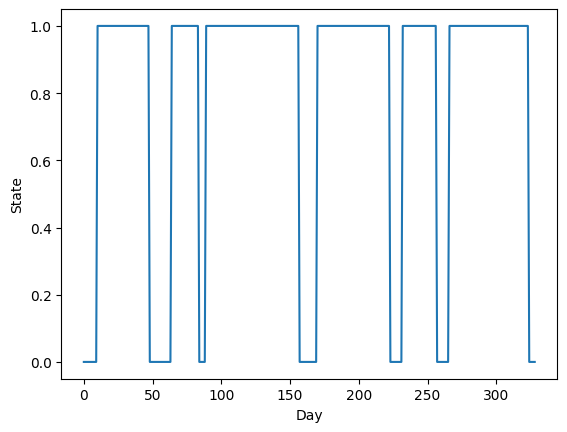

Weibull Distribution:
Scale: 51.840715891956926
Shape: 2.6751381615795244

LogNormal Distribution:
Mean: 2.154844832834546Des: 0.3402184095339078


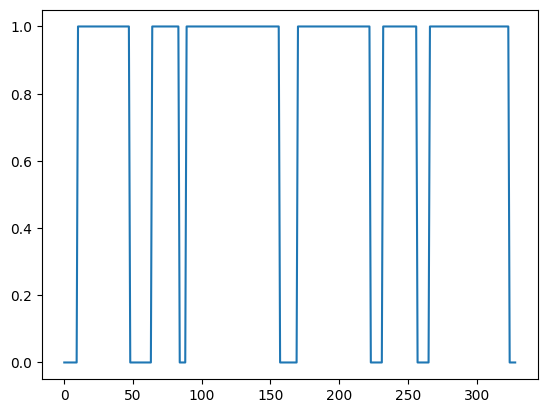

In [4]:
for i in range(1):
    print(i)
    thermoelectrics[i].plot(0, 365)
    thermoelectrics[i].get_distributions_info()

In [42]:
def get_next_general_event(thermoelectrics_list, days, current_day):
    next_event = days
    next_thermoelectric = None
    for t in thermoelectrics_list:
        tmp = t.get_next_future_event_day()
        if tmp < next_event and tmp >= current_day:
            next_event = tmp
            next_thermoelectric = t
    return (next_event, next_thermoelectric)

In [40]:
def simulate(thermoelectrics, days, agent=None):
    working_thermoelectrics = []
    working_thermoelectrics.append(np.ones(len(thermoelectrics)))

    event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, 0)

    for current_day in range(0, days):
        
        if agent is not None:
            agent.Manage_Thermoelectrics()

        while(event_thermoelectric != None and np.floor(event_date) == current_day):
            event_thermoelectric.pop_next_future_event()
            event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, current_day)

        thermoelectrics_state = [t.is_working() for t in thermoelectrics]
        working_thermoelectrics.append(thermoelectrics_state)    

        if agent is not None:
            agent.Manage_Circuits()

    return working_thermoelectrics

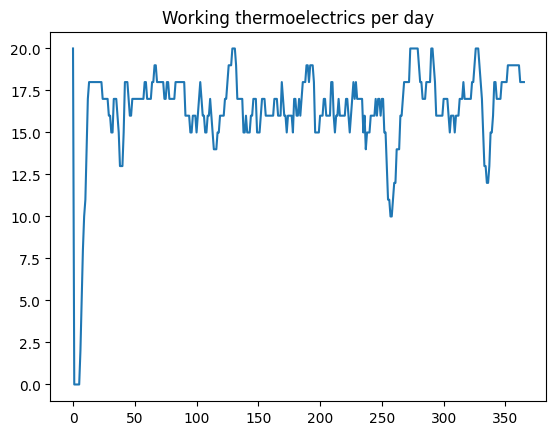

In [43]:
tmp = copy.deepcopy(thermoelectrics)
working_thermoelectrics = simulate(tmp, days)
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]


plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()

# Select best thermoelectric mantainance strategy

In [8]:
def average_worktime(planification, days, amount):
    
    total_sum = 0
    total_intervals = 0

    for i in range(amount):
        sum = 0
        for j in range(days):
            if planification[j][i]:
                sum += 1
            elif sum != 0:
                total_sum += sum
                total_intervals += 1
                sum = 0
        if sum != 0:
            total_sum += sum
            total_intervals += 1
            sum = 0 
    return total_sum / total_intervals


In [9]:
def k_simulation(days, thermoelectrics_amount, k):
    
    average = 0
    
    for i in range(k):
        thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)
        thermoelectrics_state = simulate(thermoelectrics, days)
        average += average_worktime(thermoelectrics_state, days, thermoelectrics_amount)
        
    return average / k

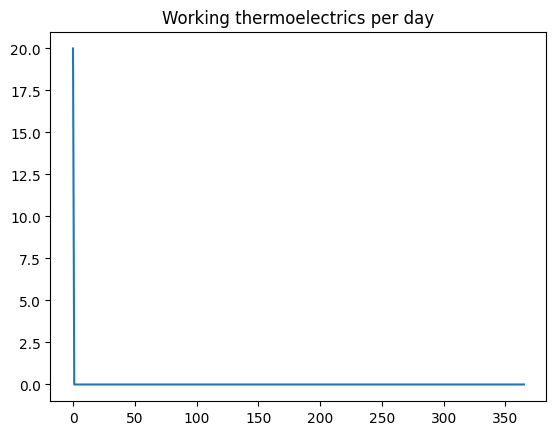

In [10]:
tmp = copy.deepcopy(thermoelectrics)

average = k_simulation(days, 20, 10)

def give_mantainance_heuristic():
    current_day = 600
    for thermoelectric in tmp:
        if not thermoelectric.is_working():
            continue
        last_repair = thermoelectric.get_last_repair_day()
        if current_day - last_repair >= average:
            thermoelectric.repair_and_replanificate(current_day, days, LogNormal(rnd.uniform(1.5,2), rnd.uniform(0.2,0.4)))

def empty_func():
    pass

working_thermoelectrics = simulate(tmp, days, Agent(give_mantainance_heuristic, empty_func))
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()